In [1]:
import tfscreen
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## tfscreen walkthrough

This notebook walks through the tfscreen simulation and analysis pipeline. It assumes that you downloaded the tfscreen [repo](https://github.com/harmslab/tfscreen) and that you installed the libray by running "`pip install .`" inside the base tfscreen directory. 


### Simulation inputs

+ **calibration.json**: A text file that defines how operator occupancy relates to growth rate under different conditions. This is made by fitting a line to the growth rate vs. fractional occupancy for the wildtype transcription factor in the presence of the markers and selection used in the full screen. This file is generated using the "calibrate-growth.ipynb" notebook. The calibration file is used for both simulation and analysis.
+ **input.yaml**: A text file that defines the simulation parameters. It has comments throughout that explain what the different features are. 

### Run the simulation

Simulate transformation, growth, and sequencing. The simulation parameters are defined in the yaml_file. It takes about an hour on my macbook to run using a linkage model of the lac repressor on our full experiment (~250k genotypes, 20 conditions, three time points, and 1.5 billion reads). The "demonstration.yaml" file is scaled down and takes ~10 minutes. 

The simulation will generate three csv files: "output/demo-phenotype_df.csv", "output/demo-combined_df.csv", and "output/demo-sample_df.csv".

In [2]:
tfscreen.simulate.run_simulation(yaml_file="demonstration.yaml",
                                output_prefix="demo",
                                output_path="output")

loading configuration 'demonstration.yaml':   0%|                                                             …

generating library sequences:   0%|                                                                           …

setting up conditions:   0%|                                                                                  …

calculating phenotypes:   0%|                                                                                 …

simulating transformation:   0%|                                                                              …

initializing sample:   0%|                                                                                    …

getting initial populations:   0%|                                                                            …

growing populations:   0%|                                                                                    …

sequencing samples:   0%|                                                                                     …

Assembling combined dataframe.:   0%|          | 0/60 [00:00<?, ?it/s]

writing final output.


 Simulation 'demo' complete.


### Outputs

#### Genotype dataframe

This holds the ground truth for genotypes in the simulation. 

+ **genotype**: genotype of the transcription factor
+ **num_muts**: number of mutations in this genotype
+ **site_1**: first mutation site
+ **site_2**: second mutation site
+ **mut_1**: mutant amino acid at first mutation site
+ **mut_2**: mutant amino acid at second mutation site
+ **wt_1**: wildtype amino acid at first mutation site
+ **wt_2**: wildtype amino acid at second mutation site
+ **ddG**: array of ddG effects on all states caused by these mutation(s)
+ **k_shift**: overall growth rate effect of these mutations
+ **lnA0**: initial population of this genotype just prior to being placed in IPTG for outgrowth. 

In [3]:
genotype_df = tfscreen.util.read_dataframe("output/demo-genotype_df.csv")
genotype_df

,genotype,num_muts,site_1,site_2,mut_1,mut_2,wt_1,wt_2,ddG,k_shift,lnA0
0,wt,0,NaN,NaN,NaN,NaN,NaN,NaN,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.],0.000000,5.435504
1,V30A,1,30.0,NaN,A,NaN,V,NaN,[0. 0.96 1.3878 0.9587 0.9587 0.9587 0.9...,-0.003481,4.009711
2,V30C,1,30.0,NaN,C,NaN,V,NaN,[0. 1.3719 1.7512 1.3716 1.3718 1.3718 1.3...,-0.001162,2.066017
3,V30D,1,30.0,NaN,D,NaN,V,NaN,[0. 1.7499 2.0449 1.7501 1.7503 1.7503 1.7...,-0.007198,3.007955
4,V30F,1,30.0,NaN,F,NaN,V,NaN,[0. 0.9768 0.9198 0.9758 0.9761 0.9761 0.9...,-0.003485,1.920009
...,...,...,...,...,...,...,...,...,...,...,...
10095,E36Y/V95P,2,36.0,95.0,Y,P,E,V,[0. 3.5954 2.9969 2.6491 2.6492 2.6492 2.6...,-0.013238,-0.653460
10096,E36Y/V95R,2,36.0,95.0,Y,R,E,V,[0. 1.2998 1.2628 2.0314 2.033 2.033 2.0...,-0.018923,-0.522535
10097,E36Y/V95S,2,36.0,95.0,Y,S,E,V,[0. 1.6933 1.5014 1.9275 1.9303 1.9303 1.9...,-0.010155,0.119649
10098,E36Y/V95T,2,36.0,95.0,Y,T,E,V,[0. 1.1155 1.0594 1.3561 1.3588 1.3588 1.3...,-0.015619,0.462339


#### Phenotype dataframe

This holds the ground truth for phenotypes in the simulation. 

+ **genotype**: genotype of the transcription factor
+ **marker**: marker that is under control of the transcription factor operator
+ **select**: whether selection is applied for the marker. For example, kanamycin for kanR or 4CP for pheS.
+ **obs**: fractional saturation of the DNA operator (what we want to estimate with the experiment)
+ **base_growth_rate**: growth rate of a cell expressing the lac repressor genotype at [IPTG] in the absence of marker or selection
+ **marker_growth_rate**: growth rate of a cell expressing the lac repressor genotype at [IPTG] with marker but no selection
+ **overall_growth_rate**: growth rate of a cell expressing the lac repressor genotype at [IPTG] with the marker and selection conditions of this sample

In [4]:
phenotype_df = tfscreen.util.read_dataframe("output/demo-phenotype_df.csv")
phenotype_df

,genotype,marker,select,iptg,obs,base_growth_rate,marker_growth_rate,overall_growth_rate
0,wt,kanR,0,0.0000,0.904963,0.022728,0.024592,0.024592
1,wt,kanR,0,1.0000,0.038889,0.024245,0.026037,0.026037
2,wt,kanR,1,0.0000,0.904963,0.022728,0.024592,0.003704
3,wt,kanR,1,0.0001,0.904241,0.023235,0.025099,0.004215
4,wt,kanR,1,0.0010,0.894721,0.023487,0.025351,0.004514
...,...,...,...,...,...,...,...,...
201995,E36Y/V95Y,pheS,1,0.0030,0.869173,-0.000548,-0.002724,-0.012618
201996,E36Y/V95Y,pheS,1,0.0100,0.715085,-0.000416,-0.002550,-0.013810
201997,E36Y/V95Y,pheS,1,0.0300,0.371548,-0.000295,-0.002337,-0.016641
201998,E36Y/V95Y,pheS,1,0.1000,0.120436,-0.000163,-0.002137,-0.018667


#### Combined dataframe

This is the core output from an experiment (and simulation). It has every genotype in all conditions, even if a particular genotype is not seen in a particular condition. 

+ **genotype**: genotype of the transcription factor
+ **genotype_number**: a unique number given to each genotype
+ **timepoint**: An observation timepoint, defined by the string: `replicate|marker|selection|iptg|time`. This corresponds to a specific (HTS run + multiplexing barcode) pair.
+ **sample**: A replicate grown under specific conditions, defined by: `replicate|marker|selection|iptg`. This corresponds to a tube growing up that is sampled at various time points. The string is the index for the row defining those conditions in the sample dataframe. 
+ **sample_number**: This records the row of the sample dataframe that defines the growth conditions for the sample.
+ **time**: time (in minutes) since placing into selection conditions
+ **counts**: number of reads observed for this genotype at this time in this sample.
+ **total_cfu_mL_at_time**: total number of cells in this sample at this time
+ **total_counts_at_time**: total number of sequencing read of this sample at this time


In [5]:
combined_df = tfscreen.util.read_dataframe("output/demo-combined_df.csv")
combined_df

,genotype,genotype_number,timepoint,sample,sample_number,time,counts,total_cfu_mL_at_time,total_counts_at_time
0,wt,0,1|kanR|0|0.0|80,1|kanR|0|0.0,0,80,8145,120288.272206,833333
1,wt,0,1|kanR|0|0.0|95,1|kanR|0|0.0,0,95,8992,154925.639194,833333
2,wt,0,1|kanR|0|0.0|110,1|kanR|0|0.0,0,110,9770,200127.067295,833333
3,wt,0,1|kanR|0|1.0|80,1|kanR|0|1.0,1,80,8426,141087.990147,833333
4,wt,0,1|kanR|0|1.0|95,1|kanR|0|1.0,1,95,9223,185712.565571,833333
...,...,...,...,...,...,...,...,...,...
605995,E36Y/V95Y,10099,1|pheS|1|0.1|110,1|pheS|1|0.1,18,110,41,22414.878836,833333
605996,E36Y/V95Y,10099,1|pheS|1|0.1|125,1|pheS|1|0.1,18,125,51,21777.072863,833333
605997,E36Y/V95Y,10099,1|pheS|1|1.0|95,1|pheS|1|1.0,19,95,72,22775.670322,833333
605998,E36Y/V95Y,10099,1|pheS|1|1.0|110,1|pheS|1|1.0,19,110,62,21976.542429,833333


#### Sample dataframe

This holds the conditions for each sample. 

+ **sample**: A replicate grown under specific conditions, defined by: `replicate|marker|selection|iptg`. This corresponds to a tube growing up over time that is sampled at various time points. This is the index in the sample dataframe.
+ **replicate**: Biological replicate number (for whole experiment)
+ **marker**: marker that is under control of the transcription factor operator
+ **select**: whether selection is applied for the marker. For example, kanamycin for kanR or 4CP for pheS.
+ **iptg**: iptg concentration (in mM)

In [6]:
# Read in the same dataframe and make the index "sample"
sample_df = tfscreen.util.read_dataframe("output/demo-sample_df.csv",
                                         index_column="sample")
sample_df

Renaming column 'Unnamed: 0' -> 'sample'


,replicate,marker,select,iptg
sample,,,,
1|kanR|0|0.0,1,kanR,0,0.0000
1|kanR|0|1.0,1,kanR,0,1.0000
1|kanR|1|0.0,1,kanR,1,0.0000
1|kanR|1|0.0001,1,kanR,1,0.0001
1|kanR|1|0.001,1,kanR,1,0.0010
1|kanR|1|0.003,1,kanR,1,0.0030
1|kanR|1|0.01,1,kanR,1,0.0100
1|kanR|1|0.03,1,kanR,1,0.0300
1|kanR|1|0.1,1,kanR,1,0.1000


### Estimate growth rates

Once we have our simulated (or real) data, we need to estimate the growth rate for each genotype in each sample. This is done using the `estimate_growth_rates` function. By default, this assumes that all samples started as a single pot, and thus that each genotype has a single initial concentration. It uses this information to infer an initial number of cells for each genotype, which it then adds as a pseudo t = 0 point to all fits. If then fits the model $ln(A) = ln(A_{0}) + kt$ to the data, where $ln(A)$ is the log(cfu/mL). 

In [7]:
param_df, pred_df = tfscreen.analysis.counts_to_growth(combined_df=combined_df,
                                                           sample_df=sample_df,
                                                           calibration_data="2025-08-27_calibration.json",
                                                           k_fit_method="wls",
                                                           num_time0_iterations=3,
                                                           use_inferred_zero_point=True)

In [8]:
param_df

,sample,replicate,marker,select,iptg,genotype,A0_est,A0_std,k_est,k_std,fit_attempted
0,1|kanR|0|0.0,1,kanR,0,0.0000,wt,5.022488,0.016485,0.022927,0.000180,True
1,1|kanR|0|1.0,1,kanR,0,1.0000,wt,5.067655,0.016450,0.024696,0.000180,True
2,1|kanR|1|0.0,1,kanR,1,0.0000,wt,5.012697,0.016670,0.002403,0.000095,True
3,1|kanR|1|0.0001,1,kanR,1,0.0001,wt,5.033864,0.016678,0.002811,0.000095,True
4,1|kanR|1|0.001,1,kanR,1,0.0010,wt,5.038209,0.016659,0.003252,0.000095,True
...,...,...,...,...,...,...,...,...,...,...,...
201995,1|pheS|1|0.003,1,pheS,1,0.0030,E36Y/V95Y,1.258604,0.276297,-0.003299,0.002593,True
201996,1|pheS|1|0.01,1,pheS,1,0.0100,E36Y/V95Y,1.430153,0.275824,-0.006264,0.002618,True
201997,1|pheS|1|0.03,1,pheS,1,0.0300,E36Y/V95Y,1.166258,0.279227,-0.006644,0.002606,True
201998,1|pheS|1|0.1,1,pheS,1,0.1000,E36Y/V95Y,1.227024,0.279514,-0.010002,0.002632,True


#### parameter dataframe

The parameter dataframe holds the estimated $k$ (growth rates) and $A_{0}$ (initial populations) for each genotype in each condition. It adds five new columns:
+ **A0_est** and **A0_std**: estimated initial ln(cfu/mL) and standard error on that estimate for the genotype under these conditions.
+ **k_est** and **k_std**: estimated growth rate and standard error on that estimate for the genotype under these conditions.
+ **fit_attempted**: whether or not the function even tried to fit the data. 


In [9]:
param_df

,sample,replicate,marker,select,iptg,genotype,A0_est,A0_std,k_est,k_std,fit_attempted
0,1|kanR|0|0.0,1,kanR,0,0.0000,wt,5.022488,0.016485,0.022927,0.000180,True
1,1|kanR|0|1.0,1,kanR,0,1.0000,wt,5.067655,0.016450,0.024696,0.000180,True
2,1|kanR|1|0.0,1,kanR,1,0.0000,wt,5.012697,0.016670,0.002403,0.000095,True
3,1|kanR|1|0.0001,1,kanR,1,0.0001,wt,5.033864,0.016678,0.002811,0.000095,True
4,1|kanR|1|0.001,1,kanR,1,0.0010,wt,5.038209,0.016659,0.003252,0.000095,True
...,...,...,...,...,...,...,...,...,...,...,...
201995,1|pheS|1|0.003,1,pheS,1,0.0030,E36Y/V95Y,1.258604,0.276297,-0.003299,0.002593,True
201996,1|pheS|1|0.01,1,pheS,1,0.0100,E36Y/V95Y,1.430153,0.275824,-0.006264,0.002618,True
201997,1|pheS|1|0.03,1,pheS,1,0.0300,E36Y/V95Y,1.166258,0.279227,-0.006644,0.002606,True
201998,1|pheS|1|0.1,1,pheS,1,0.1000,E36Y/V95Y,1.227024,0.279514,-0.010002,0.002632,True


#### prediction dataframe

The prediction dataframe holds ln(cfu/mL) observed versus the ln(cfu/mL) predicted by the model for each gentype at each condition. This is useful for making sure the regression points do indeed match the experimental points. 

+ **obs**: observed ln(cfu/mL)
+ **pred**: model prediction of ln(cfu/mL)

In [10]:
pred_df

,sample,genotype,time,obs,pred
1,1|kanR|0|0.0,wt,80.0,6.852695,6.856671
2,1|kanR|0|0.0,wt,95.0,7.204669,7.200580
3,1|kanR|0|0.0,wt,110.0,7.543648,7.544489
5,1|kanR|0|1.0,wt,80.0,7.046101,7.043347
6,1|kanR|0|1.0,wt,95.0,7.411286,7.413790
...,...,...,...,...,...
807994,1|pheS|1|0.1,E36Y/V95Y,110.0,NaN,NaN
807995,1|pheS|1|0.1,E36Y/V95Y,125.0,NaN,NaN
807997,1|pheS|1|1.0,E36Y/V95Y,95.0,NaN,NaN
807998,1|pheS|1|1.0,E36Y/V95Y,110.0,NaN,NaN


Once useful analysis tool is to plot [predicted ln(cfu/mL) - obs ln(cfu/mL)] vs. [observed ln(cfu/mL)]. A perfect model will land exactly on the 0 line. Models that systematically vary with magnitude (say, systematically overestimating small values) will fall off the line. Since this is based on observed ln(cfu/mL), we can run this on real data, even without knowing the underlying growth rates. 

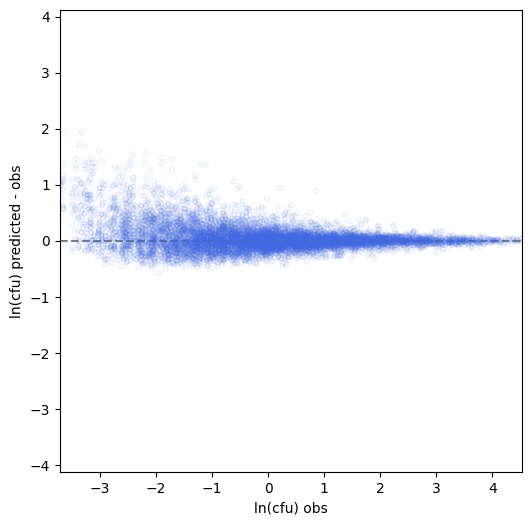

In [11]:

_ = tfscreen.plot.err_vs_mag(obs=pred_df["obs"],
                             pred=pred_df["pred"],
                             axis_name="ln(cfu)")

#### Compare estimated to real growth rates

Since we simulated the dataset, we know the underlying growth rates. We can thus ask how good we are at extracting these known values. The following code block extracts the underlying growth rates (`k_real`) for which we successfully performed a fit. It then generates plots to help us analyze the results and spits out some statistics on the fit quality. Some things to look for:

1. **Correlation**: is there a strong correlation between the estimated and real k values? This can be evaluated in the in the plot on the left, as well as in the $R^2$ value in the stats output. 
2. **RMSE**: How wrong are we, on average? This is in the stats output. 
3. **Calibration**: Do our parameter uncertainty values capture the true error in our estimates? If yes, the red line on the right plot will exactly match the gray histogram. The test statistic "coverage probability" will also be 0.95. This measures the fraction of (predicted - real) parameters that land within their inferred 95% confidence intervals. If the value is *lower* than 0.95, it means that our errors are too small; if the value is *greater* than 0.95, it means our errors are too large. 

Fit attempt rate: 0.9626633663366336


{'pct_success': np.float64(1.0),
 'rmse': np.float64(0.003862279508937912),
 'normalized_rmse': np.float64(0.1162816809244754),
 'pearson_r': np.float64(0.8948553886840028),
 'r_squared': np.float64(0.8007661666567978),
 'mean_error': np.float64(0.0009262637542298844),
 'coverage_prob': np.float64(0.6547274989972127),
 'residual_corr': np.float64(-0.3793508142499912),
 'residual_corr_p_value': np.float64(0.0),
 'bp_p_value': np.float64(0.0)}

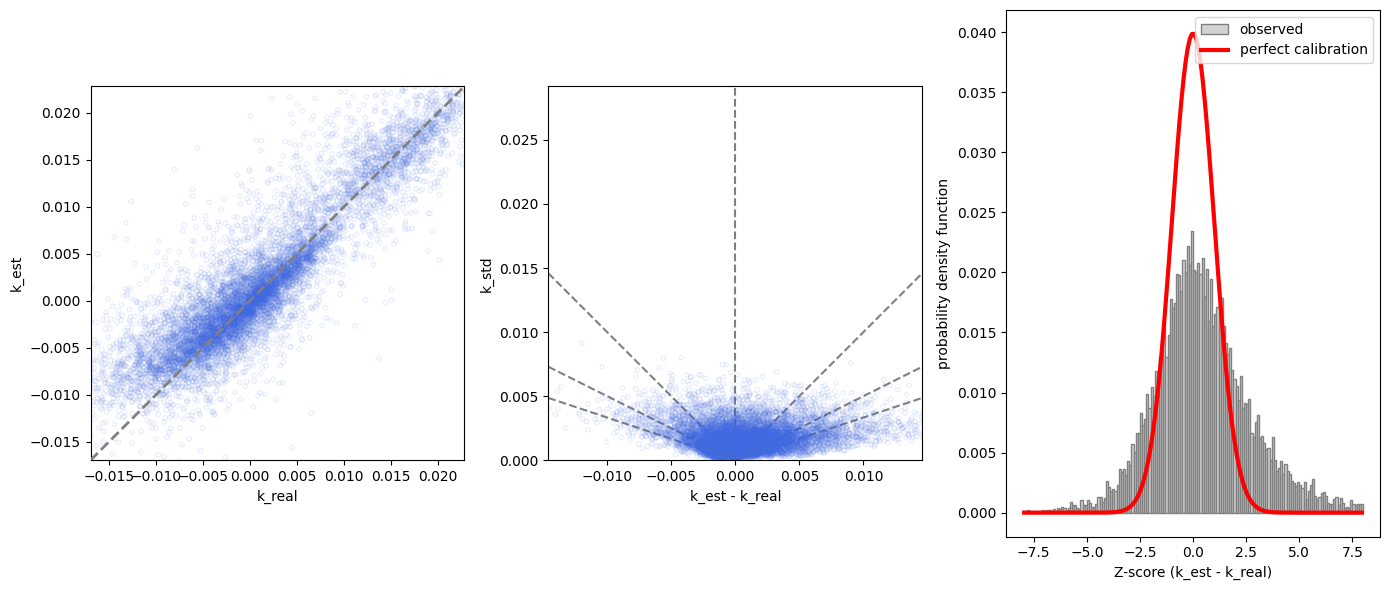

In [12]:
# get real growth rates from simulation input
k_real = np.array(phenotype_df["overall_growth_rate"])

# Grab growth rates where the fit was attempted (had enough
# sequence reads to fit). 
keep_mask = param_df["fit_attempted"]
k_est = np.array(param_df.loc[keep_mask,"k_est"])
k_std = np.array(param_df.loc[keep_mask,"k_std"])
k_real = k_real[keep_mask]

# Plot a summary comparison of fit and real values
_ = tfscreen.plot.est_v_real_summary(
    k_est,
    k_std,
    k_real,
    axis_prefix="k"
)

# Write out some statistics describing success
print("Fit attempt rate:",len(k_est)/len(phenotype_df))
tfscreen.fitting.stats_test_suite(k_est,
                                  k_std,
                                  k_real)

### Estimate fractional occupancy of the operator

Our next step is to use the observed growth rates with information about each condition to estimate the fractional occupancy of the operator ($\theta$). This relies on our calibration, which maps growth rate to occupancy. Because we have two markers in our core design--kanamcyin, which kills when the gene kanR is repressed and 4CP, which kills when gene pheS is transcribed--we have two estimates of ($\theta$) at each IPTG concentration. 

The function `estimate_df` takes our estimated growth rates and uncertainties, plus our calibration data. It returns two dataframes: "growth_df" and "theta_df."

In [13]:

growth_df, theta_df = tfscreen.analysis.growth_to_theta(
    param_df,
    calibration_data="2025-08-27_calibration.json",
    method="nls"
)

  0%|          | 0/1995 [00:00<?, ?it/s]

Creating final dataframes.


#### growth dataframe

The growth dataframe holds the estimated effect of each mutant on intrinsic growth rate. This is not generally what we're interested in, but it's a nuisance parameter we need to estimate for all genotypes. (It likely correlates with folding/expression/toxicity, but that relationship is difficult to pull apart without other data we are not collecting in this screen). 

+ **mut_effect**: estimated effect of the mutation on intrinsic growth rate
+ **mut_effect_std**: standard error on the estimated effect on growth rate. 


In [14]:
growth_df

,genotype,mut_effect_est,mut_effect_std
0,wt,-0.001431,0.000019
1,V30A,-0.004744,0.000030
2,V30C,-0.002685,0.000092
3,V30D,-0.007333,0.000072
4,V30F,-0.004020,0.000120
...,...,...,...
10020,E36Y/V95P,-0.011637,0.000599
10021,E36Y/V95R,-0.020352,0.000551
10022,E36Y/V95S,-0.007522,0.000260
10023,E36Y/V95T,-0.014027,0.000233


The effects of mutations on the intrinsic growth rates are not estimated particularly well--we systematically overestimate the rates of the slowest growing genotypes. 

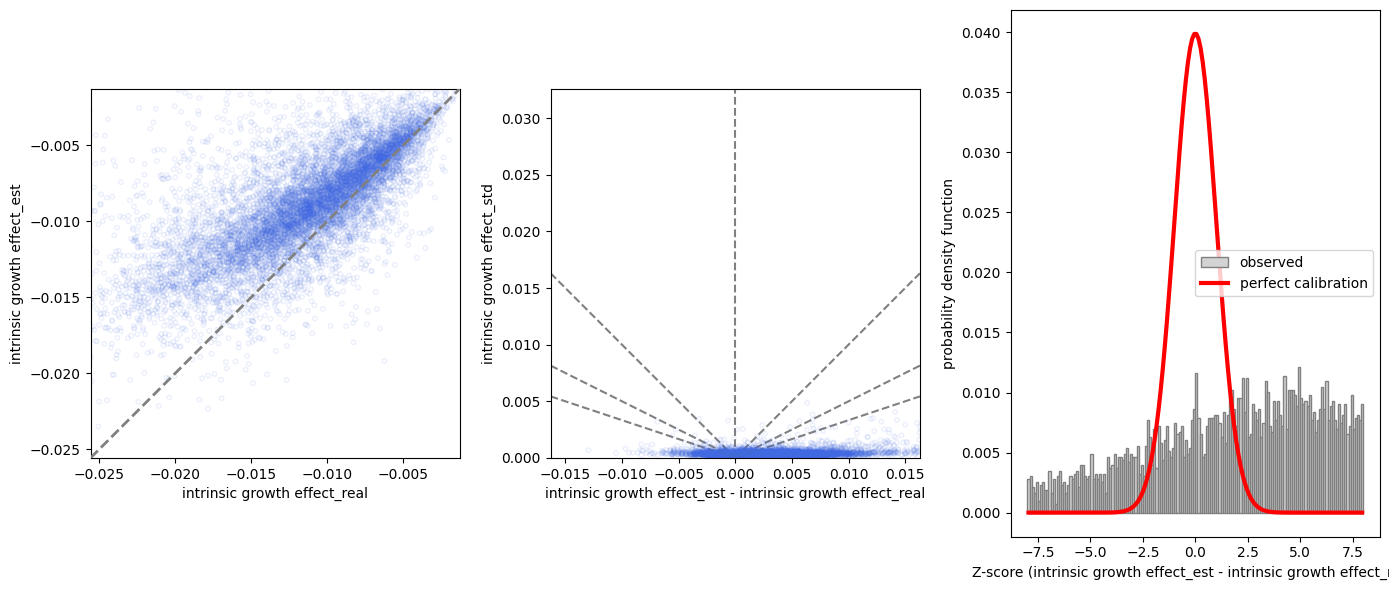

In [15]:

calibration_dict = tfscreen.calibration.read_calibration("2025-08-27_calibration.json")
wt_growth_rate = calibration_dict["param_values"][0]

unique_genotype_df = phenotype_df[(phenotype_df["marker"] == "kanR") & 
                                  (phenotype_df["iptg"] == 0.0 ) & 
                                  (phenotype_df["select"] == 1)]

genotype_fit = unique_genotype_df["genotype"].isin(growth_df["genotype"])

mut_growth_real = np.array(unique_genotype_df.loc[genotype_fit,"base_growth_rate"]) - wt_growth_rate
mut_growth_est = np.array(growth_df["mut_effect_est"]) 
mut_growth_std = np.array(growth_df["mut_effect_std"])

_ = tfscreen.plot.est_v_real_summary(mut_growth_est,
                                     mut_growth_std,
                                     mut_growth_real,
                                     axis_prefix="intrinsic growth effect")
    



#### theta dataframe

This holds our core inference: operator occupancy for each of the samples in our experiment. 
+ **theta_est**: estimated occupancy
+ **theta_std**: standard error on our estimated occupancy


In [16]:
theta_df

,genotype,iptg,theta_est,theta_std
0,wt,0.0000,8.961751e-01,0.008787
1,wt,0.0001,8.947967e-01,0.008806
2,wt,0.0010,8.745637e-01,0.008790
3,wt,0.0030,8.345642e-01,0.008806
4,wt,0.0100,6.734052e-01,0.009222
...,...,...,...,...
79076,E36Y/V95Y,0.0030,8.735355e-01,0.107695
79077,E36Y/V95Y,0.0100,5.869461e-01,0.111995
79078,E36Y/V95Y,0.0300,4.389381e-01,0.111861
79079,E36Y/V95Y,0.1000,5.462090e-17,0.111620


This is generally well estimated by our protocol. 

Fit attempt rate: 0.9787252475247524


{'pct_success': np.float64(1.0),
 'rmse': np.float64(0.13758861555009747),
 'normalized_rmse': np.float64(0.15663497141040403),
 'pearson_r': np.float64(0.9167769143180657),
 'r_squared': np.float64(0.840479910626554),
 'mean_error': np.float64(-0.0084349024712169),
 'coverage_prob': np.float64(0.9238249389866087),
 'residual_corr': np.float64(-0.18855680704932026),
 'residual_corr_p_value': np.float64(0.0),
 'bp_p_value': np.float64(4.1230598492873485e-27)}

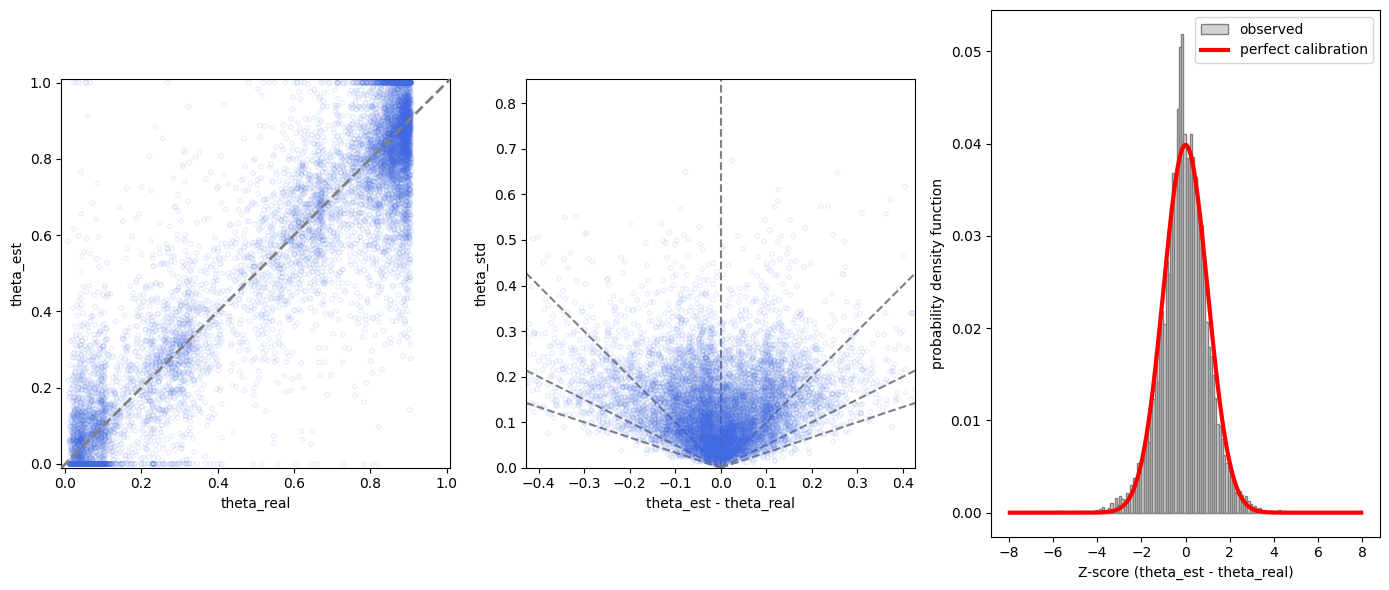

In [17]:
# Grab kanR with selection obs, which will have all iptg concentrations exactly once
phenotype_unique_iptg = phenotype_df[np.logical_and(phenotype_df["marker"] == "kanR",
                            phenotype_df["select"] == 1)]

# Get real, estimated, and standard errors on estimated theta
theta_est = np.array(theta_df["theta_est"])
theta_std = np.array(theta_df["theta_std"])
theta_real = np.array(phenotype_unique_iptg["obs"])

# Grab all genotype/iptg pairs from the phenotype_unique_iptg (input) and theta_out (output)
input_keys = list(zip(list([str(g) for g in phenotype_unique_iptg["genotype"]]),list(phenotype_unique_iptg["iptg"])))
output_keys = list(zip(list([str(g) for g in theta_df["genotype"]]),list(theta_df["iptg"])))

# Create masks to only grab shared phenotypes seen in both output and input
input_mask = np.array(pd.Series(input_keys).isin(pd.Series(output_keys)))
output_mask = np.array(pd.Series(output_keys).isin(pd.Series(input_keys)))

# Mask theta so we're only comparing results that were fit
theta_est = theta_est[output_mask]
theta_std = theta_std[output_mask]
theta_real = theta_real[input_mask]

# Plot a summary comparison of fit and real values
_ = tfscreen.plot.est_v_real_summary(theta_est,
                                            theta_std,
                                            theta_real,
                                            axis_prefix="theta")

# Write out some statistics describing success
print("Fit attempt rate:",len(theta_est)/len(input_keys))
tfscreen.fitting.stats_test_suite(theta_est,
                                  theta_std,
                                  theta_real)

### Fit a Hill model to the data


In [18]:
hill_param_df, hill_pred_df = tfscreen.analysis.theta_to_hill(theta_df)

Fitting Genotypes:   0%|          | 0/10025 [00:00<?, ?it/s]

<Axes: xlabel='[iptg] (mM)', ylabel='fractional occupancy'>

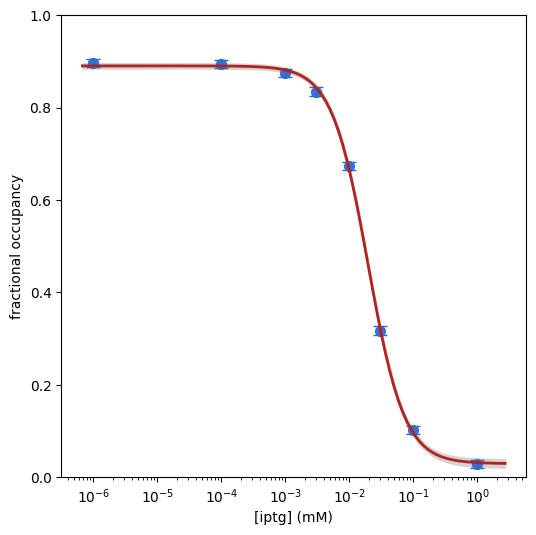

In [19]:
tfscreen.plot.hill_fit(theta_df,
                       hill_pred_df,genotype='wt',scatter_kwargs={"s":50,
                                                                  "facecolor":"royalblue"})

We can also check out individual mutations. The following code block does this for four mutations. Note the double mutant has higher uncertainty because it has many fewer counts in the library. 

wt,V30A,V30C,V30D,V30F,V30G,V30H,V30I,V30L,V30N,V30P,V30R,V30S,V30T,V30Y,S31A,S31C,S31D,S31F,S31G,S31H,S31I,S31L,S31N,S31P,S31R,S31T,S31V,S31Y,A32C,A32D,A32F,A32G,A32H,A32I,A32L,A32N,A32P,A32R,A32S,A32T,A32V,A32Y,K33A,K33C,K33D,K33F,K33G,K33H,K33I,K33L,K33N,K33P,K33R,K33S,K33T,K33V,K33Y,T34A,T34C,T34D,T34F,T34G,T34H,T34I,T34L,T34N,T34P,T34R,T34S,T34V,T34Y,R35A,R35C,R35D,R35F,R35G,R35H,R35I,R35L,R35N,R35P,R35S,R35T,R35V,R35Y,E36A,E36C,E36D,E36F,E36G,E36H,E36I,E36L,E36N,E36P,E36R,E36S,E36T,E36V,E36Y,Q89A,Q89C,Q89D,Q89F,Q89G,Q89H,Q89I,Q89L,Q89N,Q89P,Q89R,Q89S,Q89T,Q89V,Q89Y,L90A,L90C,L90D,L90F,L90G,L90H,L90I,L90N,L90P,L90R,L90S,L90T,L90V,L90Y,G91A,G91C,G91D,G91F,G91H,G91I,G91L,G91N,G91P,G91R,G91S,G91T,G91V,G91Y,A92C,A92D,A92F,A92G,A92H,A92I,A92L,A92N,A92P,A92R,A92S,A92T,A92V,A92Y,S93A,S93C,S93D,S93F,S93G,S93H,S93I,S93L,S93N,S93P,S93R,S93T,S93V,S93Y,V94A,V94C,V94D,V94F,V94G,V94H,V94I,V94L,V94N,V94P,V94R,V94S,V94T,V94Y,V95A,V95C,V95D,V95F,V95G,V95H,V95I,V95L,V95N,V95P,V95R,V95S,V95T,V95Y


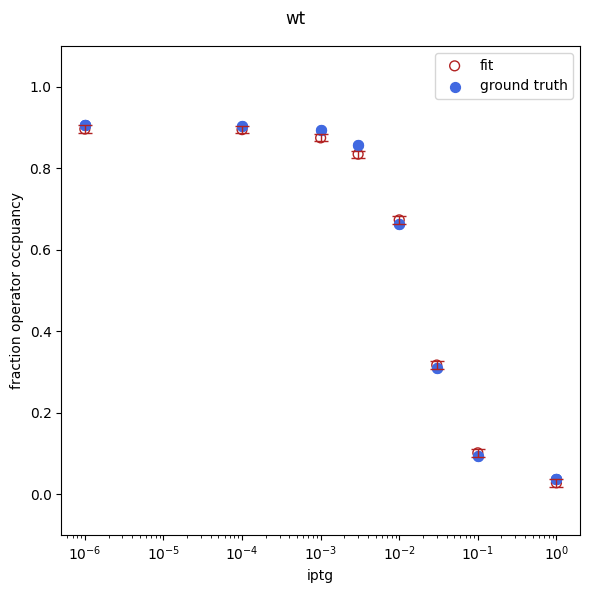

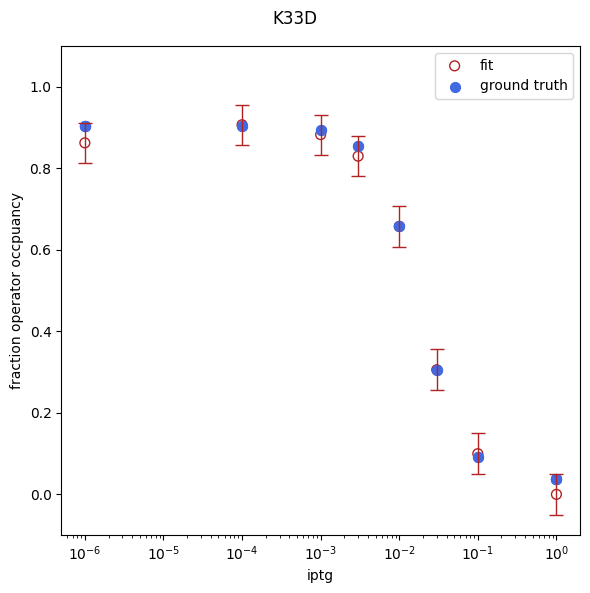

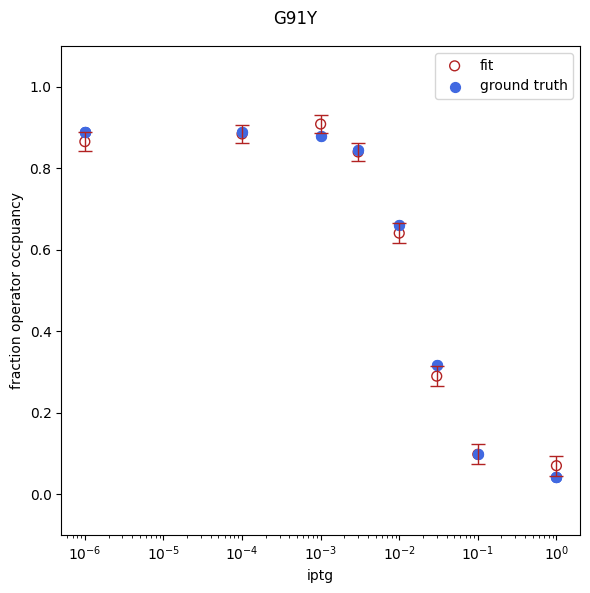

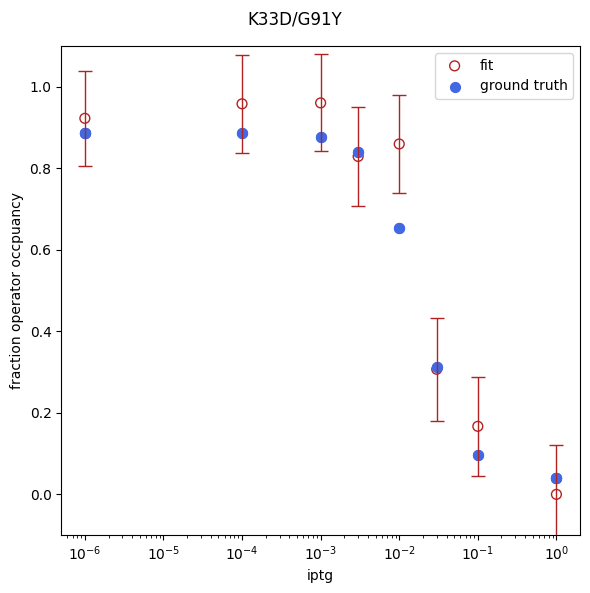

In [20]:

## Print out unique single mutations 
muts = pd.unique(theta_df["genotype"])
print(",".join([m for m in muts if len(m.split("/")) == 1]))



def plot_single_genotype(genotype,
                         theta_df,
                         phenotype_df):

    this_output_df = theta_df.loc[theta_df["genotype"] == genotype,:].copy()
    this_output_df.loc[this_output_df["iptg"] == 0,"iptg"] = 1e-6
    
    this_input_df = phenotype_df[phenotype_df["genotype"] == genotype].copy()
    this_input_df.loc[this_input_df["iptg"] == 0,"iptg"] = 1e-6
    
    fig, ax = plt.subplots(1,figsize=(6,6))
    
    ax.errorbar(this_output_df["iptg"],
                this_output_df["theta_est"],
                yerr=this_output_df["theta_std"],
                lw=0,
                elinewidth=1,
                capsize=5,
                color='firebrick')
    ax.scatter(this_output_df["iptg"],
               this_output_df["theta_est"],
               s=50,
               edgecolor='firebrick',
               facecolor="none",
               label="fit")
    ax.scatter(this_input_df["iptg"],
               this_input_df["obs"],
               s=50,
               color='royalblue',
               label="ground truth")
    
    ax.legend()

    fig.suptitle(genotype)
    ax.set_xscale("log")
    ax.set_ylim(-0.1,1.1)
    ax.set_xlabel("iptg")
    ax.set_ylabel("fraction operator occpuancy")
    fig.tight_layout()
    
    return fig, ax

_ = plot_single_genotype("wt",theta_df,phenotype_df)
_ = plot_single_genotype("K33D",theta_df,phenotype_df)
_ = plot_single_genotype("G91Y",theta_df,phenotype_df)
_ = plot_single_genotype("K33D/G91Y",theta_df,phenotype_df)